In [495]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [497]:
'''
# Parametrize a sphere
def sphere_r(u, v):
    return np.array([np.sin(v) * np.cos(u), np.sin(v) * np.sin(u), np.cos(v)])
'''


# Parametrize an ellipsoid
a,b,c = 3.0,1.5,1.0
def ellipsoid_r(u,v):
    return np.array([a*np.sin(v)*np.cos(u),b*np.sin(v)*np.sin(u),c*np.cos(v)])


'''
#Tannery pear
a=2.0
sqrt_2 = np.sqrt(2)
def pear_r(u,v):
    return np.array([a*np.sin(u)*np.cos(u)*np.cos(v),a*np.sin(u)*np.cos(u)*np.sin(v),2*sqrt_2*a*np.sin(u)])
'''

    

'\n#Tannery pear\na=2.0\nsqrt_2 = np.sqrt(2)\ndef pear_r(u,v):\n    return np.array([a*np.sin(u)*np.cos(u)*np.cos(v),a*np.sin(u)*np.cos(u)*np.sin(v),2*sqrt_2*a*np.sin(u)])\n'

In [499]:
# 1) Plot surface with scaled axes
def plot_param_surface(r_func, u_range, v_range, Nu, Nv, cmap='viridis'):
    """
    Plot a 3D parametric surface defined by r_func(u, v) with equal aspect ratio.

    Parameters:
    - r_func : function(u, v) -> np.array([x, y, z])
    - u_range: (u_min, u_max)
    - v_range: (v_min, v_max)
    - Nu, Nv : resolution in u and v
    - cmap    : colormap

    Returns:
    - fig, ax : matplotlib figure and axes objects
    """
    # Create parameter grids
    u = np.linspace(u_range[0], u_range[1], Nu)
    v = np.linspace(v_range[0], v_range[1], Nv)
    U, V = np.meshgrid(u, v)
    
    # Allocate coordinate arrays
    X = np.zeros(U.shape)
    Y = np.zeros(U.shape)
    Z = np.zeros(U.shape)
    
    # Compute surface coordinates
    for i in range(Nv):
        for j in range(Nu):
            X[i, j], Y[i, j], Z[i, j] = r_func(U[i, j], V[i, j])
    
    # Create figure and 3D axes
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(projection='3d')
    
    # Plot the surface
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cmap, edgecolor='none')
    
    # === aspect‐ratio fix so graph is scaled properly ===
    max_range = np.array([X.max() - X.min(),Y.max() - Y.min(),Z.max() - Z.min()]).max()
    mid_x = 0.5 * (X.max() + X.min())
    mid_y = 0.5 * (Y.max() + Y.min())
    mid_z = 0.5 * (Z.max() + Z.min())
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)
    # =========================
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('Parametric Surface')
    plt.tight_layout()
    plt.show()
    
    return fig, ax





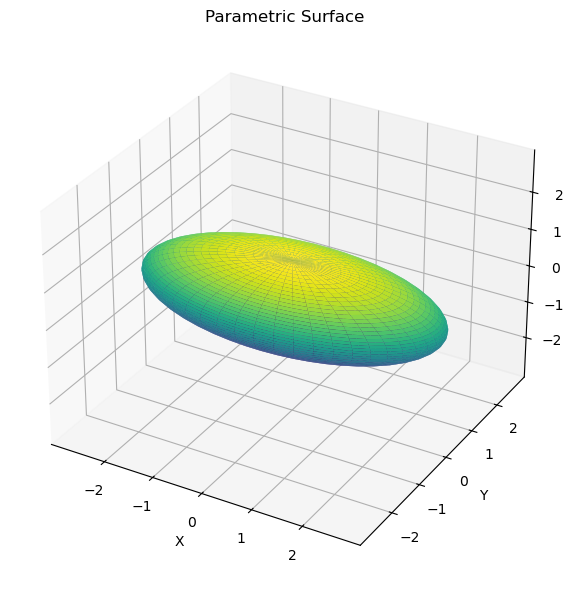

(<Figure size 600x600 with 1 Axes>,
 <Axes3D: title={'center': 'Parametric Surface'}, xlabel='X', ylabel='Y', zlabel='Z'>)

In [501]:
# Visualize the unit sphere
#must find ranges to close the surface
r_func=ellipsoid_r #MAKE SURE TO CHANGE IF NEW SURFACE
u_range=(0, 2 * np.pi)
v_range=(0, np.pi)
Nu=50
Nv=50
cmap='viridis'


plot_param_surface(r_func,u_range,v_range,Nu,Nv,cmap)

In [503]:
#center of mass of shape when made uniformly dense 


# 2) Mesh builder that wraps the u-seam
def build_param_mesh_periodic(r_func, u_range, v_range, Nu, Nv):

    """
    Build a closed triangular mesh of the surface by wrapping u at the seam.

    Parameters:
    - r_func   : function(u, v) -> np.array([x, y, z])
    - u_range  : (u_min, u_max)
    - v_range  : (v_min, v_max)
    - Nu, Nv   : resolution in u and v

    Returns:
    - triangles: list of np.ndarray of shape (3,3) representing mesh triangles
    """
    
    umin, umax = u_range
    vmin, vmax = v_range
    us = np.linspace(umin, umax, Nu, endpoint=False)
    vs = np.linspace(vmin, vmax, Nv)
    verts = np.zeros((Nv, Nu, 3))
    for i, v in enumerate(vs):
        for j, u in enumerate(us):
            verts[i,j] = r_func(u, v)
    tris = []
    for i in range(Nv-1):
        for j in range(Nu):
            j2 = (j+1) % Nu
            v0 = verts[i  , j ]
            v1 = verts[i  , j2]
            v2 = verts[i+1, j ]
            v3 = verts[i+1, j2]
            tris.append(np.stack([v0, v1, v3]))
            tris.append(np.stack([v0, v3, v2]))
    return tris

'''
# 3) Find centroid
def compute_volume_centroid(triangles, ref_point=np.zeros(3)):
    """
    Compute the volume centroid (center of mass) and total volume of a closed mesh by
    decomposing into tetrahedra formed by each triangle and a reference interior point.

    Parameters:
    - triangles : list of np.ndarray of shape (3,3) representing mesh triangles
    - ref_point : np.array([x, y, z]) reference point inside the mesh (default origin)

    Returns:
    - centroid  : np.array([x_c, y_c, z_c])
    - total_vol : float
    """
    total_vol = 0.0
    centroid = np.zeros(3)
    for v0, v1, v2 in triangles:
        # signed volume of tetrahedron (ref_point, v0, v1, v2)
        vol = np.dot(v0 - ref_point, np.cross(v1 - ref_point, v2 - ref_point)) / 6.0
        # centroid of that tetrahedron
        tet_centroid = (ref_point + v0 + v1 + v2) / 4.0
        centroid += tet_centroid * vol
        total_vol += vol
    centroid /= total_vol
    return centroid, abs(total_vol)
'''

# 3) Find centroid
def compute_volume_centroid(triangles, ref_point=None):
    """
    Compute the volume centroid and total volume of a closed, star-shaped mesh by
    decomposing it into tetrahedra (ref_point, v0, v1, v2), using ABSOLUTE volumes.

    Parameters:
    - triangles : list of np.ndarray shape (3,3), each a mesh triangle [v0, v1, v2]
    - ref_point : np.array([x, y, z]) interior reference point (default origin)

    Returns:
    - centroid  : np.array([x_c, y_c, z_c])
    - total_vol : float
    """
    if ref_point is None:
        ref_point = np.zeros(3)

    total_vol = 0.0
    centroid  = np.zeros(3)

    for v0, v1, v2 in triangles:
        # signed volume of tetrahedron
        vol_signed = np.dot(v0 - ref_point,
                            np.cross(v1 - ref_point,
                                     v2 - ref_point)) / 6.0
        # use absolute to avoid orientation issues
        vol = abs(vol_signed)

        # centroid of that tetrahedron
        tet_centroid = (ref_point + v0 + v1 + v2) / 4.0

        # accumulate
        centroid  += tet_centroid * vol
        total_vol += vol

    centroid /= total_vol
    return centroid, total_vol

In [505]:
#Compute the solid‐body centroid and volume
tris = build_param_mesh_periodic(r_func, u_range, v_range, Nu, Nv)
vol_centroid = compute_volume_centroid(tris)[0] #ref point already defined previously
volume = compute_volume_centroid(tris)[1]
print("Centroid:", vol_centroid)
print("Volume:", volume)

Centroid: [-8.63015818e-18  1.14462071e-18 -8.18006393e-17]
Volume: 18.780671741872563


In [507]:
#determine if point is inside surface or not using ray casting and triangle algorithm

#each tiny quadrilateral which comprise the surface is sampled then split into a triangle
#bounding‐volume hierarchy to hide most triangles behind a few bounding boxes
#Möller–Trumbore determines if R(t)= orig + t*dir hits the triangle surface (is intersection between the edges
#Ray‐AABB intersection we do a super-cheap check to see if the ray intersect that node’s axis-aligned box
#if no overlap we skip the subtree
#Traversal and “odd‐even” when we call hits = traverse_bvh(bvh_root, orig=point, dir, dir_inv) we see if ray 
#ray misses root's box. Otherwise If leaf → test each triangle, count how many intersections
#If internal → recurse into left and right children, sum their counts.
#inside = (hits % 2) == 1 to see if crossing surface amount is odd or even as ray casting does



import numpy as np

# 4) Ray–triangle intersection (Möller–Trumbore)
def ray_intersect_triangle(orig, dir, v0, v1, v2):
    eps = 1e-9
    e1 = v1 - v0
    e2 = v2 - v0
    h  = np.cross(dir, e2)
    a  = np.dot(e1, h)
    if abs(a) < eps:
        return False
    f = 1.0 / a
    s = orig - v0
    u = f * np.dot(s, h)
    if u < 0 or u > 1:
        return False
    q = np.cross(s, e1)
    v = f * np.dot(dir, q)
    if v < 0 or u + v > 1:
        return False
    t = f * np.dot(e2, q)
    return t > eps

# 5) Robust ray–AABB intersection (no divide-by-zero)
def ray_intersect_aabb(orig, dir, bbox_min, bbox_max):
    tmin, tmax = -np.inf, np.inf
    for i in range(3):
        di = dir[i]
        if abs(di) > 1e-9:
            inv = 1.0 / di
            t1 = (bbox_min[i] - orig[i]) * inv
            t2 = (bbox_max[i] - orig[i]) * inv
            tmin = max(tmin, min(t1, t2))
            tmax = min(tmax, max(t1, t2))
        else:
            # parallel: origin must lie within slab
            if orig[i] < bbox_min[i] or orig[i] > bbox_max[i]:
                return False
    return tmax >= max(tmin, 0.0)

# 6) BVH node (stores bbox_min / bbox_max)
class BVHNode:
    def __init__(self, triangles, max_triangles=8):
        # compute this node’s bounding box
        pts = np.concatenate(triangles)
        self.bbox_min = np.min(pts, axis=0)
        self.bbox_max = np.max(pts, axis=0)

        if len(triangles) <= max_triangles:
            # leaf
            self.triangles = triangles
            self.left = self.right = None
        else:
            # internal: split along longest axis
            self.triangles = None
            centroids = [tri.mean(axis=0) for tri in triangles]
            axis = np.argmax(self.bbox_max - self.bbox_min)
            order = np.argsort([c[axis] for c in centroids])
            mid = len(triangles) // 2
            left_tris  = [triangles[i] for i in order[:mid]]
            right_tris = [triangles[i] for i in order[mid:]]
            self.left  = BVHNode(left_tris,  max_triangles)
            self.right = BVHNode(right_tris, max_triangles)

# 7) Traverse BVH to count ray-triangle hits
def traverse_bvh(node, orig, dir):
    # cull by the node’s box
    if not ray_intersect_aabb(orig, dir, node.bbox_min, node.bbox_max):
        return 0
    count = 0
    if node.triangles is not None:
        # leaf: brute-force
        for v0, v1, v2 in node.triangles:
            if ray_intersect_triangle(orig, dir, v0, v1, v2):
                count += 1
    else:
        # internal: recurse
        count += traverse_bvh(node.left,  orig, dir)
        count += traverse_bvh(node.right, orig, dir)
    return count

# 8) Point-in-solid test using odd-even rule
def is_point_inside_bvh(bvh_root, point, dir_vec=None):
    orig = np.array(point, dtype=float)
    if dir_vec is None:
        dir_vec = np.array([1.0, 0.1234, 0.4321])
    dir = dir_vec / np.linalg.norm(dir_vec)
    hits = traverse_bvh(bvh_root, orig, dir)
    return (hits % 2) == 1





In [521]:
# Test point:
if __name__ == "__main__":
    
    # Build mesh and BVH
    bvh = BVHNode(tris, max_triangles=8) #tris from before
    # Test points
    print(is_point_inside_bvh(bvh, [0.5,0,0]))  # True - inside closed mesh
    print(is_point_inside_bvh(bvh, [3.0,0,0]))  # False - outside closed mesh

True
False


In [523]:
# 9) Anti-coulomb field for outside surface case


def compute_E_r2(R, r_func, u_range, v_range, Nu, Nv, K):
    """
    Compute the “anti‐Coulomb” field at point R from a parametrized closed surface.
    The integrand grows like +r^2 instead of decaying like 1/r^2.

    Parameters:
    - R         : np.array([x, y, z]) observation point
    - r_func    : function(u, v) -> np.array([x, y, z]) parametrization of the surface
    - u_range   : (u_min, u_max)
    - v_range   : (v_min, v_max)
    - Nu, Nv    : int, resolution in u and v
    - K         : overall constant (e.g. σ/(4πε₀))

    Returns:
    - E         : np.array([Ex, Ey, Ez]) the computed field vector
    """
    umin, umax = u_range
    vmin, vmax = v_range
    du = (umax - umin) / Nu
    dv = (vmax - vmin) / Nv

    E = np.zeros(3)
    delta = 1e-6

    for i in range(Nu):
        u = umin + (i + 0.5) * du
        for j in range(Nv):
            v = vmin + (j + 0.5) * dv
            r_uv = r_func(u, v)

            # estimate partial derivatives
            ru = (r_func(u + delta, v) - r_uv) / delta
            rv = (r_func(u, v + delta) - r_uv) / delta

            # area element
            w = np.linalg.norm(np.cross(ru, rv)) * du * dv

            # vector from surface patch to R
            d = R - r_uv
            r_mag = np.linalg.norm(d)
            if r_mag == 0:
                continue

            # anti‐Coulomb kernel: direction * r^2
            E += (d / r_mag) * (r_mag**2) * w

    return K * E


In [525]:
#ε0 = 8.854187817e-12
#σ  = 1e-6      # surface‐charge density for anti‐Coulomb case
#K2 = σ/(4*np.pi*ε0)

#q_inside = σ * total_surface_area   # or some chosen total charge
#K1 = q_inside/(4*np.pi*ε0)

K = 1.0

# 10) Compute field based on inside or outside condition
#Inside just drawn right to centroid and rewarded 
#Outside requires full surface calculation and is for punishment
def compute_field(R):
    """
    Hybrid field:
     - Outside the surface → anti‐Coulomb (∝ +r^2) kernel over the mesh
     - Inside the surface  → standard Coulomb ∝ 1/r^2 from the centroid
    """
    R = np.asarray(R, dtype=float)
    
    # inside vs. outside
    if is_point_inside_bvh(bvh, R):
        # standard Coulomb from the centroid
        d = R - vol_centroid
        r = np.linalg.norm(d)
        if r < 1e-12:
            return np.zeros(3)          # avoid singularity at the centroid
        else:
            return K * (d / r**3)       #K instead of K1
    else:
        # anti-Coulomb across the surface
        return compute_E_r2(R, r_func, u_range, v_range, Nu, Nv, K)

'''
# Example usage:
points_example = [
    np.array([0.0, 0.0, 2]),   # inside
    np.array([2.0, 0.0, 0.0]),   # outside
]

for P in points_example:
    E = compute_field(P)
    print(f"P={P}, E={E}")
'''

'\n# Example usage:\npoints_example = [\n    np.array([0.0, 0.0, 2]),   # inside\n    np.array([2.0, 0.0, 0.0]),   # outside\n]\n\nfor P in points_example:\n    E = compute_field(P)\n    print(f"P={P}, E={E}")\n'

In [517]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  n


Nothing done.


Computed centroid: [5.40028256e-17 1.28122973e-17 3.56812872e-16]
Computed volume: 18.799652734100416
Unique Z in points: [0.]


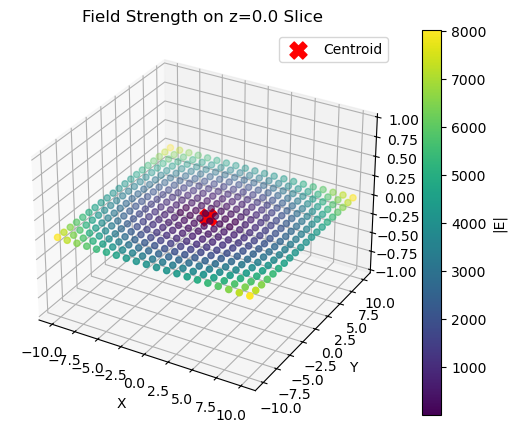

In [527]:
# Sampling resolution and plane

'''
# --- 1) Ellipsoid setup ---
a, b, c = 3.0, 1.5, 1.0
def ellipsoid_r(u, v):
    return np.array([
        a * np.sin(v) * np.cos(u),
        b * np.sin(v) * np.sin(u),
        c * np.cos(v)
    ])
'''
# Build mesh and BVH (assumes build_param_mesh_periodic & BVHNode are defined)
Nu, Nv = 80, 40
tris = build_param_mesh_periodic(ellipsoid_r, (0,2*np.pi), (0,np.pi), Nu, Nv)
bvh  = BVHNode(tris, max_triangles=8)

# Compute the volume centroid
vol_centroid, volume = compute_volume_centroid(tris)
print("Computed centroid:", vol_centroid)
print("Computed volume:", volume)

# --- 2) z=0 grid setup ---
Nx, Ny = 20, 20
xs = np.linspace(-10, 10, Nx)
ys = np.linspace(-10, 10, Ny)
slice_z = 0.0

points = np.array([[x, y, slice_z] for y in ys for x in xs])
print("Unique Z in points:", np.unique(points[:,2]))

# Compute field magnitudes
E_vals = np.array([np.linalg.norm(compute_field(p)) for p in points])

# --- 3) Plot ---
fig = plt.figure(figsize=(7,5))
ax  = fig.add_subplot(projection='3d')
sc  = ax.scatter(points[:,0], points[:,1], points[:,2], c=E_vals, cmap='viridis')

# Plot centroid
ax.scatter(
    vol_centroid[0], vol_centroid[1], vol_centroid[2],
    color='red', s=150, marker='X', label='Centroid'
)

# Force viewing window around z=0
ax.set_zlim(-1, 1)
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
plt.title(f'Field Strength on z={slice_z} Slice')
plt.colorbar(sc, label='|E|')
ax.legend()
plt.show()


In [ ]:
#We track the avatar movement with the camera to find the x,y,z coordinates
#Every three seconds we will sample the strength of the electric field at the x,y,z
#coordinate
#We will also use is_point_inside_bvh to tell if we are inside (true)
#or outside (false)
#If inside we reward proportional to the field strength
#If outside we punish proportional to the field strength
